In [143]:
# importing functions for analysis
# I find I have to run this cell twice to get nice, large plots
from functions import *
from sim_functions import *

# sometimes just need to run with the below line uncommented
plt.rcParams['figure.dpi'] = 200

# if you use your own separate scripts with function definitions
# these commands make your notebook grab updates from those script
# files every time you run a code cell in the notebook. saves time.
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulations with PENTrack

In this notebook, simulation results from PENTrack are used in conjection with the experimental analysis in order to determine various material parameters.

# Diffuse Reflection Probability

We assume that the tail of the main detection peak is the most sensitive parameter to the diffuse reflection probability of the materials. 

## Experimental Data

The example below shows a fit of the experimental data

fit will begin at 25.6 s
fit will end at 35.6 s
[[Model]]
    Model(expo)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 279
    # data points      = 100
    # variables        = 2
    chi-square         = 150.005973
    reduced chi-square = 1.53067320
    Akaike info crit   = 44.5504931
    Bayesian info crit = 49.7608334
[[Variables]]
    p0:  18.5491355 +/- 0.06468245 (0.35%) (init = 80)
    p1:  2.42866096 +/- 0.01363245 (0.56%) (init = 30)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, p1) = -0.997



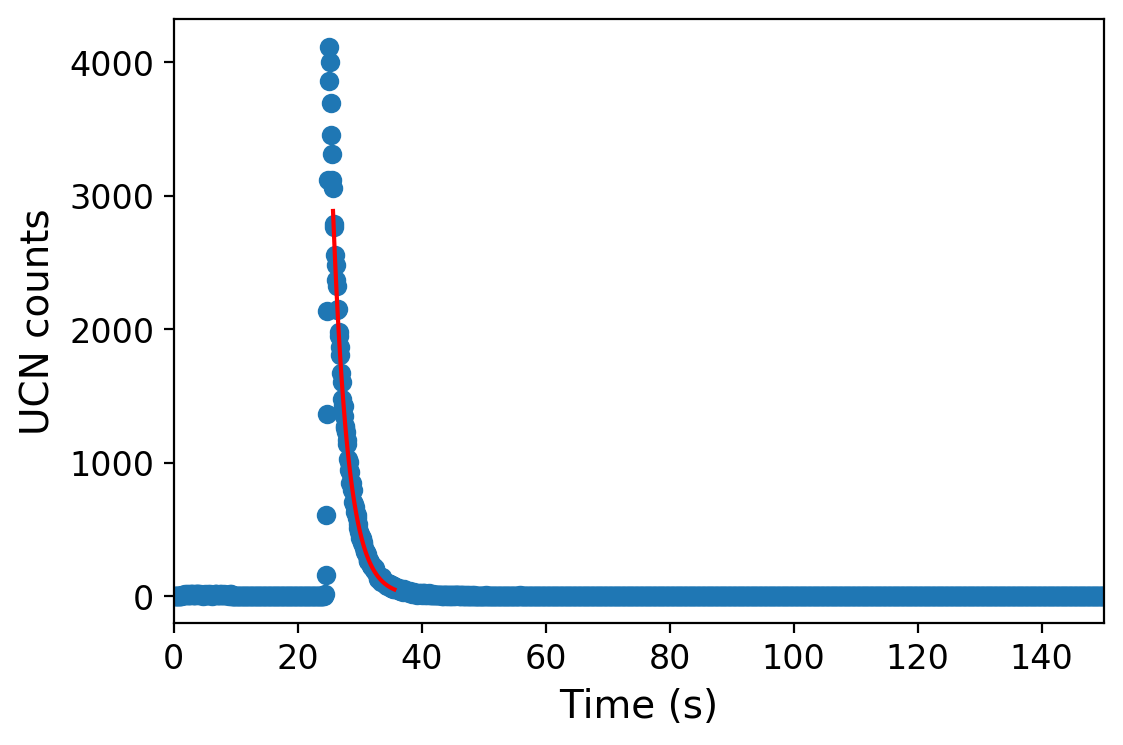

In [163]:
# load data from an example run 
filename = 'T081217_0034.tof'
arr = np.loadtxt("../data_ucn/main_detector/8/" + filename, usecols = (0,1));

# exponential function, same as ROOT's built-in 'expo'
def expo(x, p0, p1):
    return np.exp(p0 - 1/(p1) * x)

# times in seconds, specific to each run
irradiate_time = 8
fill_time = 8.6
pre_storage_time = 5
buffer_time = 4

# time length over which the fit will span
fit_span_time = 10

# compute the fit start and end times
fit_start_time = irradiate_time + fill_time + pre_storage_time + buffer_time
fit_end_time   = fit_start_time + fit_span_time

print('fit will begin at {} s'.format(fit_start_time))
print('fit will end at {} s'.format(fit_end_time))

# the experimental data is binned into 0.1s bins, and lmfit requires
# that we pass it the array we want fitted. We need to multiply these
# times to get the right indices for slicing the arrays
fit_start_index = int(fit_start_time * 10)
fit_end_index   = int(fit_end_time * 10)

# we get the arrays of counts and time, multiplying the values of t by 
# 0.1 to get it in seconds.
c = arr[fit_start_index:fit_end_index, 1]
t = arr[fit_start_index:fit_end_index,0] * 0.1

# construct weights, we deal with entries = 0 by giving them 0 weight
weights = np.zeros(np.shape(c))
for i in range(0,np.shape(c)[0]):
    if (c[i] != 0):
        weights[i] = 1 / np.sqrt(c[i])
    else:
        weights[i] = 0
        
gmodel = Model(expo)
result = gmodel.fit(c, x=t, p0=80, p1=30, weights = weights)

print(result.fit_report())
plt.plot(arr[:,0] * 0.1, arr[:,1], 'o')
plt.plot(t, result.best_fit, 'r-')
plt.xlim([0,150])
plt.ylabel('UCN counts', fontsize = 14)
plt.xlabel('Time (s)', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('../img/rough_tail_fit.pdf')
plt.show()

Next, this is performed iteratively on the data from each run in both the TRIUMF-style normalization confirguration, and the JP-style normalization configuration. 

(NOMI,s005): tau = 2.6392+/-0.0035, ave redchi = 1.9242320302886313
(NOMI,s020): tau = 2.804+/-0.004, ave redchi = 1.3689480675425476
(NOMI,s100): tau = 3.184+/-0.010, ave redchi = 0.9317114283662207
(DISK,s005): tau = 2.874+/-0.011, ave redchi = 1.8455984131671508
(DISK,s020): tau = 3.047+/-0.012, ave redchi = 1.163441005209501
(DISK,s100): tau = 3.363+/-0.029, ave redchi = 0.9536154174433256


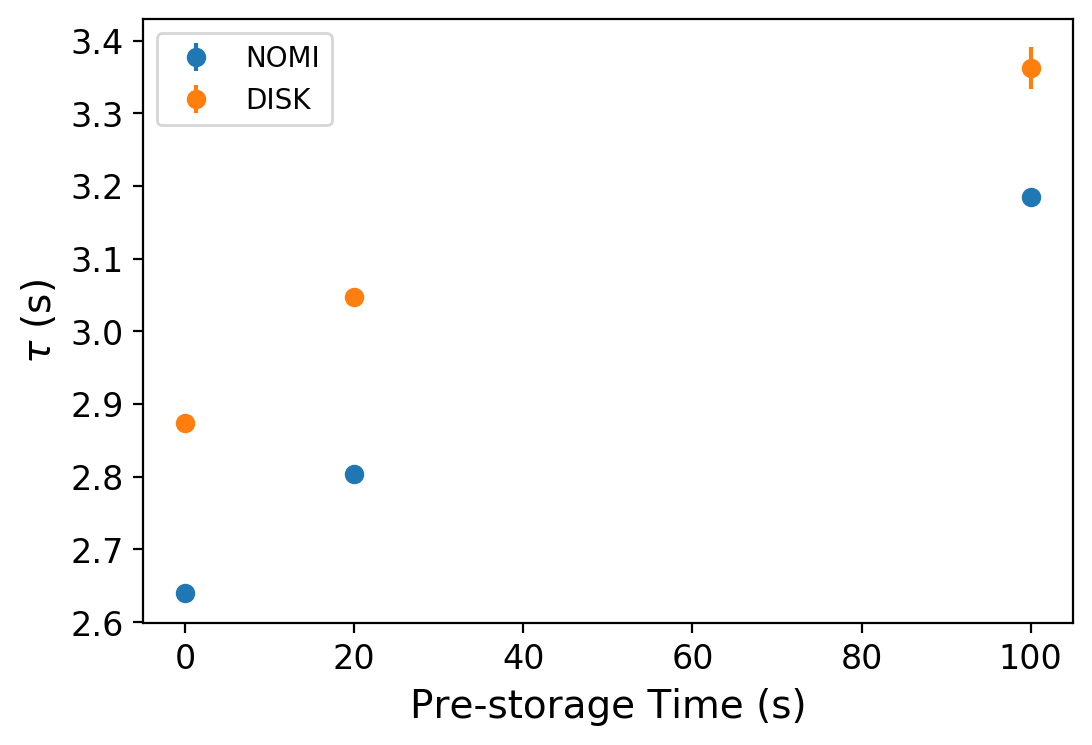

In [164]:
exp_p1_dict = fit_exp_detection_tail()

## Simulated Data

In the example below, simulation data produced with PENTrack are analysed in an analogous way to as seen above. Here data from the TRIUMF-style normalization configuration are simulated. 20,000 particles are simulated. There is a simulation with diffuse reflection probability (DRP) of 1%, and another sim. with 10%. The intention is to see if the $\tau$ values found from analyzing the experimental data can be reproduced here with simulated data. 

#####
../data_sim/NOMI_s100_dp01.root
#####

 FCN=116.07 FROM MIGRAD    STATUS=CONVERGED     539 CALLS         540 TOTAL
                     EDM=2.00403e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.02511e+00   2.28746e+00   5.33902e-04  -1.97113e-03
   2  p1           1.83964e+01   6.00366e+00   1.40040e-03  -7.52443e-04
                               ERR DEF= 0.5


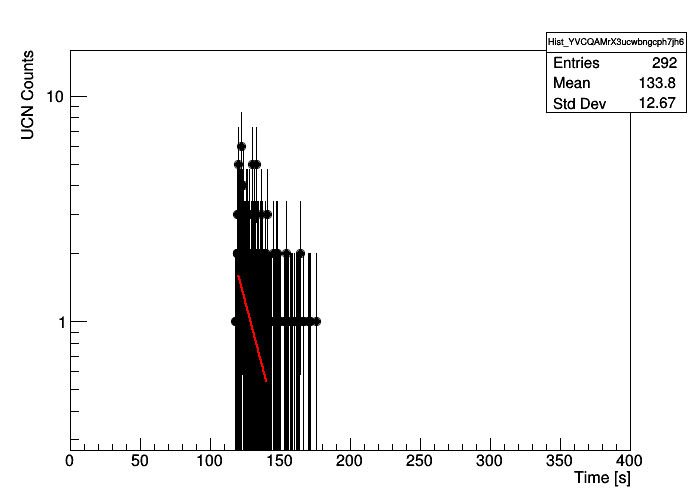

In [165]:
# example fit of simulation data, 100s pre-storage time
# DRP = 1, fit within ROOT
canvas, slope, redchi = sim_tau('NOMI', 's100', 1)

Next we perform this iteratively for different pre-storage times and diffuse reflection probabilities.

#####
../data_sim/NOMI_s005_dp01.root
#####

#####
../data_sim/NOMI_s005_dp10.root
#####

#####
../data_sim/NOMI_s020_dp01.root
#####

#####
../data_sim/NOMI_s020_dp10.root
#####

#####
../data_sim/NOMI_s100_dp01.root
#####

#####
../data_sim/NOMI_s100_dp10.root
#####

 FCN=92.1703 FROM MIGRAD    STATUS=CONVERGED     568 CALLS         569 TOTAL
                     EDM=4.4596e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.19351e+00   1.51814e-01   1.61888e-04  -2.23483e-03
   2  p1           1.11518e+01   5.68791e-01   6.06348e-04  -6.56796e-04
                               ERR DEF= 0.5
 FCN=114.384 FROM MIGRAD    STATUS=CONVERGED     587 CALLS         588 TOTAL
                     EDM=7.06394e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAM

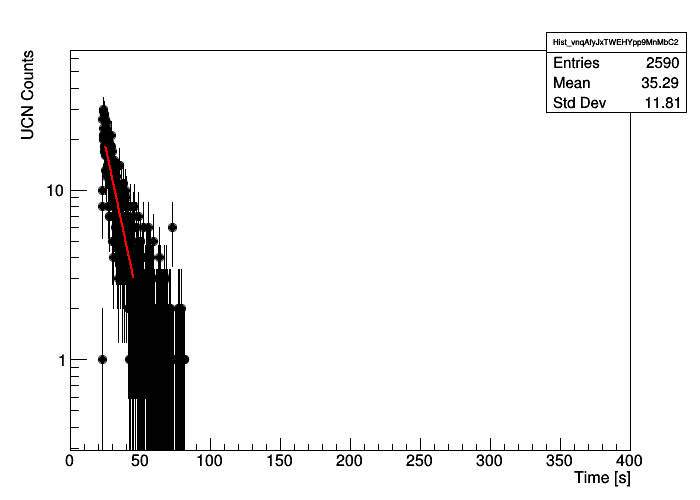

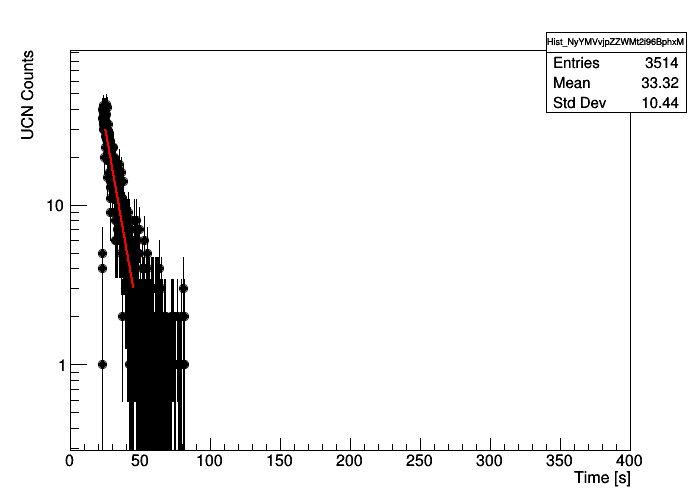

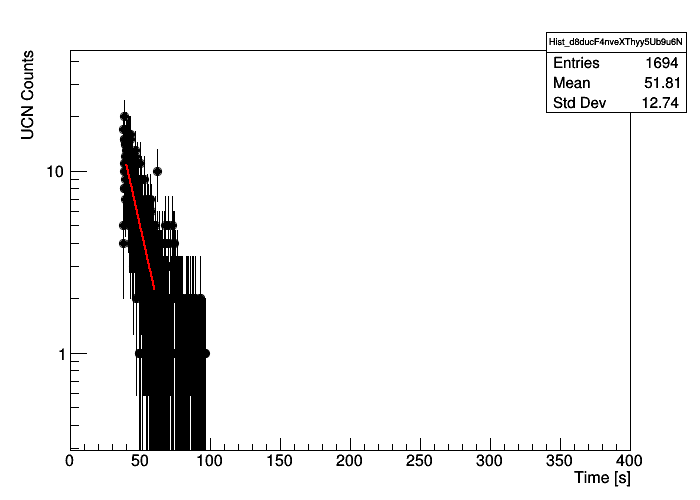

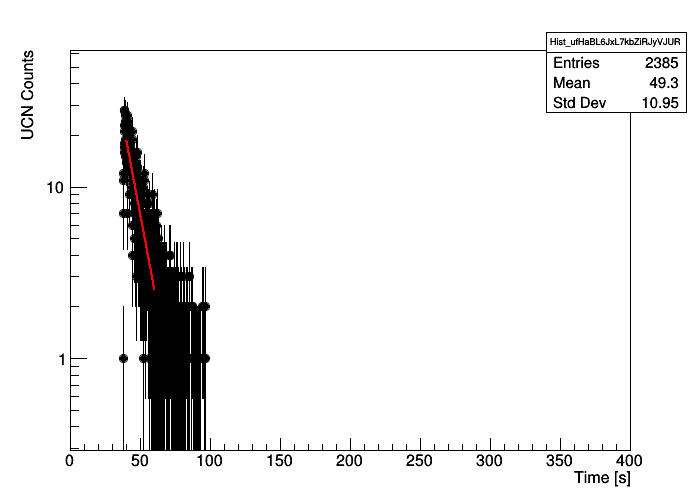

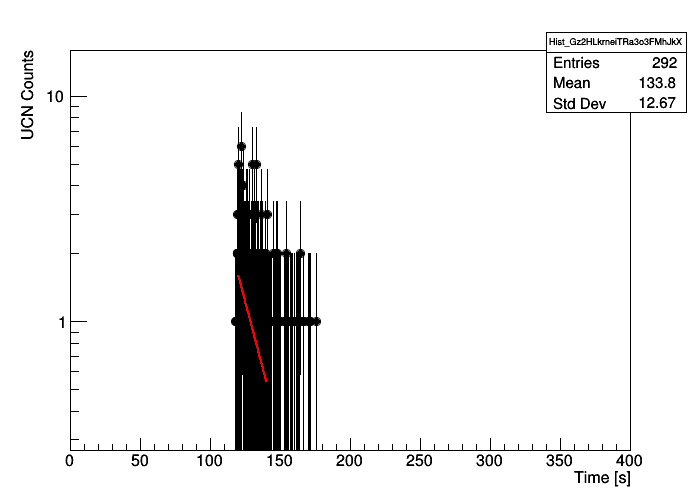

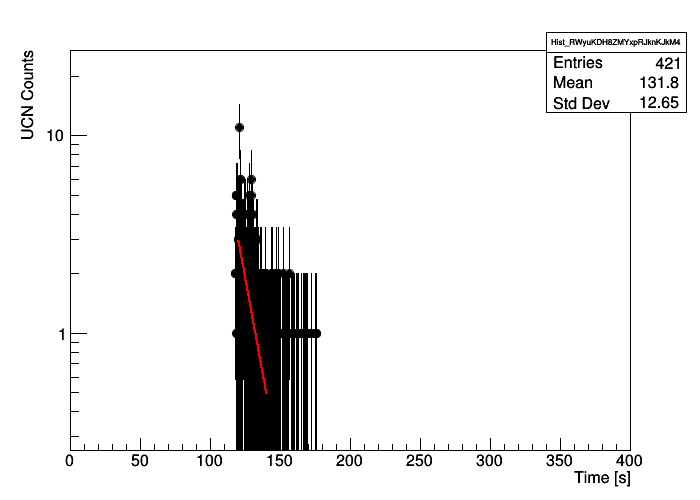

In [166]:
canvas_dict = {}
sim_p1_dict = {}

for config in ['NOMI']:
    
#     for run_type in ['s005']:
    for run_type in ['s005', 's020', 's100']:
        
#         for diffuse_probability in [10]:
        for diffuse_probability in [1, 10]:
            
            canvas, slope, redchi = sim_tau(config, run_type, diffuse_probability)
            
            canvas_dict[config, run_type, str(diffuse_probability)] = canvas
            
            sim_p1_dict[config,run_type,str(diffuse_probability)] = slope
            
            sim_p1_dict[config,run_type,str(diffuse_probability), 'redchi'] = redchi

Experimental Data (NOMI, s005), average redchi = 1.9242320302886313
Simulated Data (NOMI, s005, 1), redchi = 1.1891847724504503
Simulated Data (NOMI, s005, 10), redchi = 1.4875189426809756
Experimental Data (NOMI, s020), average redchi = 1.3689480675425476
Simulated Data (NOMI, s020, 1), redchi = 1.5317216390553867
Simulated Data (NOMI, s020, 10), redchi = 1.468151267797863
Experimental Data (NOMI, s100), average redchi = 0.9317114283662207
Simulated Data (NOMI, s100, 1), redchi = 0.6021549518803999
Simulated Data (NOMI, s100, 10), redchi = 0.8481478759478188


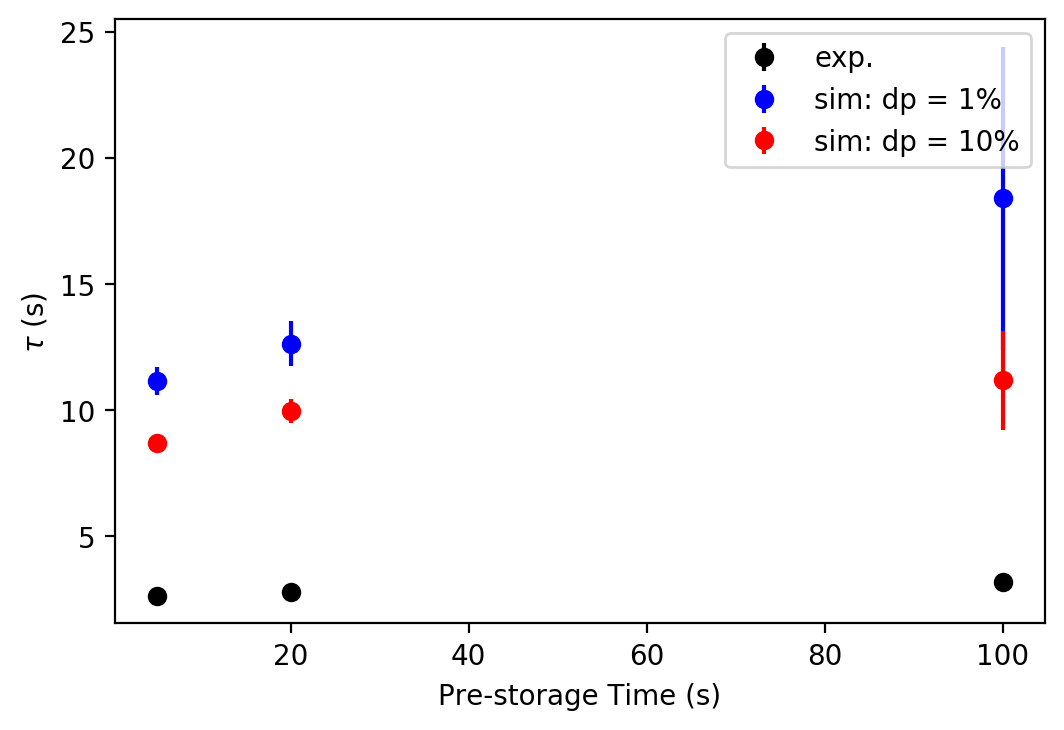

In [167]:
fig, ax = plt.subplots()
ax1 = plt.gca()

color_dict = {}
color_dict['1'] = 'b'
color_dict['10'] = 'r'

for config in ['NOMI']:
# for config in ['NOMI', 'DISK']:
    
#     for run_type in ['s005']:
    for run_type in ['s005', 's020', 's100']:
    
        exp_slope = exp_p1_dict[config, run_type]
        
        ax.errorbar(float(run_type[1:4]), exp_slope.nominal_value, yerr = exp_slope.std_dev,
                       label = 'exp.', fmt = 'o', color = 'k')
        
        print('Experimental Data (' + config + ', ' + run_type + '), average redchi = {}'.format(
        exp_p1_dict[config, run_type, 'redchi']))
        
        for diffuse_probability in [1, 10]:
    
#             if (config == 'NOMI' and run_type == 's005' and diffuse_probability == 10):
            
            slope = sim_p1_dict[config, run_type, str(diffuse_probability)]

            color = color_dict[str(diffuse_probability)]
            
            ax.errorbar(float(run_type[1:4]), slope.nominal_value, yerr = slope.std_dev,
                       label = 'sim: dp = {}%'.format(diffuse_probability), fmt = 'o', color = color)
            
            print('Simulated Data (' + config + ', ' + run_type + ', ' + 
                  str(diffuse_probability) + '), redchi = {}'.format(
            sim_p1_dict[config, run_type, str(diffuse_probability), 'redchi']))
            
                
#             if (config == 'NOMI' and run_type == 's005' and diffuse_probability == 1):
            
#                 slope = sim_p1_dict[config, run_type, str(diffuse_probability)]
                
#                 color = next(ax1._get_lines.prop_cycler)['color']
                
#                 ax.errorbar(float(run_type[1:4]), slope.nominal_value, yerr = slope.std_dev,
#                            label = 'sim: dp = {}%'.format(diffuse_probability), fmt = 'o', color = color)
        
    
ax.set_ylabel(r'$\tau$ (s)')
ax.set_xlabel('Pre-storage Time (s)')
ax.legend();
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys());

## Scratch

- make an iterative function that does all the simulation data at once
- put all the experimental analysis in here
- make a function that takes both data sets and produces publication ready plots for comparison, with full error analysis

In [35]:
str(1).zfill(2)

'01'

In [1]:
diffuse_probability = 1
f = root_open('../data_sim/' + 'NOMI' + '_' + 's100' + 
              '_dp' + str(diffuse_probability).zfill(2) + '.root')

# print data information
print('#####')
print(config + ', ' + run_type + ', dp = {}'.format(diffuse_probability))
print('#####\n')
# get the neutronend tree
end = f.Get('neutronend')

# using rootpy to define the histogram
h1 = Hist(4000, 0, 400)

# a canvas for plotting
canvas = Canvas(width=700, height=500)

# fill a histogram with only the neutrons ending in the detector
for evt in f.neutronend:
   if evt.solidend == 200: h1.Fill(evt.tend)

# set the axis ranges for viewability
#     h1.GetYaxis().SetRangeUser(0, 50)
h1.GetXaxis().SetRangeUser(0, 100)

# logarithmic y scale 
canvas.SetLogy()

# draw histogram to the canvas
h1.Draw("hist")
canvas.Draw()

# fitting
f1 = ROOT.TF1("m1","expo",25,80)
f1.SetParameters(7,-0.2)
fit = h1.Fit(f1, 'SRL')

# get the slope, or inverse tau, parameter
slope = 1

h1.GetXaxis().SetTitle('Time [s]')
h1.GetYaxis().SetTitle('UCN Counts')
h1.Draw()

NameError: name 'root_open' is not defined

In [67]:
print(f1.GetParameter(1))
print(f1.GetParError(1))

-0.09425743849006823
0.0026649604693394207
